In [1]:
import os
from PIL import Image
import cv2
import fitz  # PyMuPDF
import layoutparser as lp

In [17]:
pdf = fitz.open('IA3.pdf')
for page_num in range(len(pdf)):
    page = pdf[page_num]
    pm = page.get_pixmap()
    img = Image.frombytes("RGB", [pm.width, pm.height], pm.samples)
    img.save(f'page_{page_num}.png')
image = cv2.imread('page_6.png')
image = image[..., ::-1]

In [18]:
model = lp.Detectron2LayoutModel(
            config_path ='./config.yml', # In model catalog
            label_map  ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # Optional
        )

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


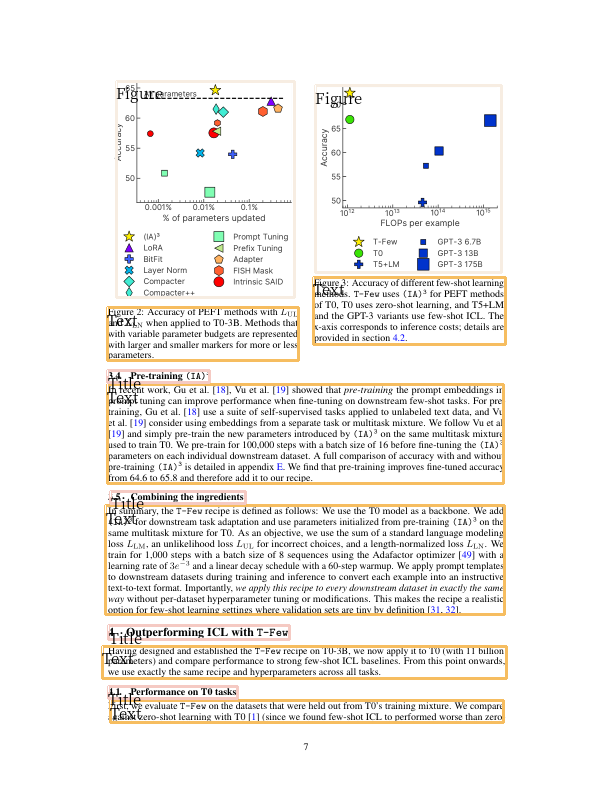

In [19]:
# 检测
layout = model.detect(image)

lp.draw_box(image, layout, box_width=3, show_element_type=True)

In [20]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])


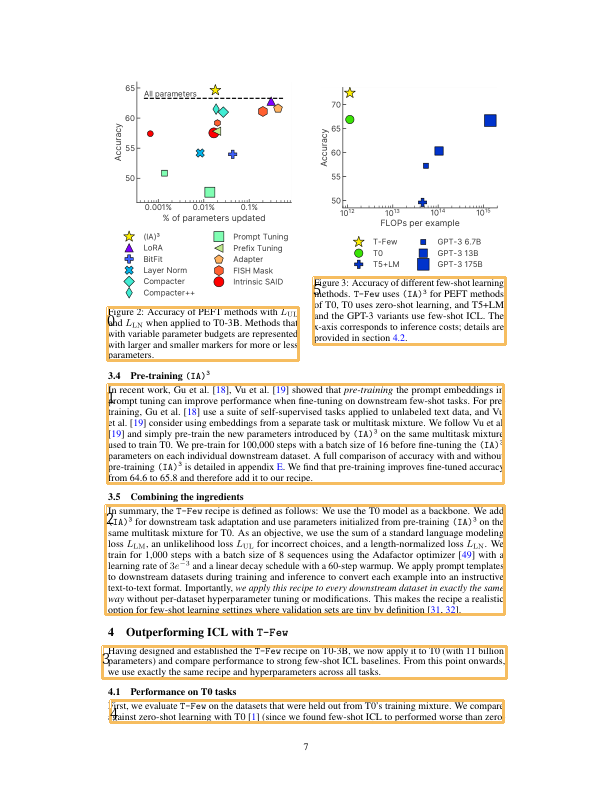

In [21]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])


lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)



In [23]:
ocr_agent = lp.TesseractAgent(languages='eng') 
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

‘Figure 2: Accuracy of PEFT methods with Lut,
and Ly when applied 19 T0'3B. Methods tht
‘ith vrlable parameter budgets ae represented,
‘vith ager and smaller markers for mare a ss
parece

---
In recent work, Gu et al. [18], Vu et al. [19] showed that pre-raining the prompt embeddings in
‘rome tuning can improve performance when fine-tuning on downsteam ew-ahot sks. Fo pe
leaning, Gu eval (Is) use suite of selFsupervised tasks applied wo unlabeled ext dts, and Va
{tal (19) consider using embeddings fom a separate sk or mulask mitre. We llow Vu ea
[19] and simply pre-tain the new paraneterenoduced by (74)® onthe same multitask misture
‘sed to ain TO. We pre-wai for 100,000 steps with a atch sizeof U6 before fine-tune (EA)®
patumeters on euch individual downsteam daact. fll comparison of accuricy with and witout
‘retaining (ZA) is deal in appendix E- We find that pre-taiing improves oe-uned accuracy
Thom 64 6 to 63-8 and therefore addi to our recipe

 

---
{In summary, the T-Few recipe